# 전처리 ver.2를 사용해 예측 모델링

후보 모델

 - Xgboost
 
 - Random Forest
 
 - Lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
directory = './energy'

train_energy = pd.read_csv(directory + '/train.csv', encoding = 'euc-kr')
test_energy = pd.read_csv(directory + '/test.csv', encoding = 'euc-kr')
sample_submission = pd.read_csv(directory + './sample_submission.csv', encoding = 'euc-kr')

In [3]:
def preprocessing_dataset(train, test):
    '''train dataset, test dataset 전처리'''
    
    # 불쾌지수, 체감온도 계산 함수 정의
    def calculate_discomfort_index(temp, humidity):
        '''불쾌지수 계산'''
        discomfort_index = 9 * temp / 5 - 0.55 * (1 - humidity / 100) * (9 * temp / 5 - 26) + 32
        return discomfort_index

    def calculate_windchill_temp(temp, wind):
        '''체감온도 계산'''
        windchill_temp = 13.12 + 0.6215 * temp - 11.37 * (wind ** 0.16) + 0.3965 * (wind ** 0.16) * temp
        return windchill_temp

    # 원본에 영향이 가지 않게 사본 저장
    train_dataset = train.copy()
    test_dataset = test.copy()

    # 1. 변수명 변경
    train_columns_name = ['num', 'date_time', 'usage', 'temp', 'wind', 'humidity', 'precipitation', 'sunshine', 'operation_non_elec', 'solar']
    test_columns_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'precipitation', 'sunshine', 'operation_non_elec', 'solar']

    train_dataset.columns = train_columns_name
    test_dataset.columns = test_columns_name

    # 2. train, test 변수의 데이터 타입 변경
    train_dtypes = {}
    train_dtypes_list = ['category', 'object', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'category', 'category']

    for index, value in enumerate(train_dataset.columns):
        train_dtypes[value] = train_dtypes_list[index]

    test_dtypes = {}
    test_dtypes_list = ['category', 'object', 'float64', 'float64', 'float64', 'float64', 'float64', 'category', 'category']

    for index, value in enumerate(test_dataset.columns):
        test_dtypes[value] = test_dtypes_list[index]

    train_dataset = train_dataset.astype(train_dtypes)
    test_dataset = test_dataset.astype(test_dtypes)

    train_dataset['date_time'] = pd.to_datetime(train_dataset['date_time'], format='%Y-%m-%d %H')
    test_dataset['date_time'] = pd.to_datetime(test_dataset['date_time'], format='%Y-%m-%d %H')

    # 3. test_dataset의 결측치 채워넣기 1 : train에서 operation_non_elec, solar 변수 가져오기
    train_operation_non_elec_solar = train_dataset.loc[:, ['num', 'operation_non_elec', 'solar']].drop_duplicates(subset = 'num').reset_index(drop = True)
    test_dataset = test_dataset.drop(columns = ['operation_non_elec', 'solar'])
    test_dataset = pd.merge(test_dataset, train_operation_non_elec_solar, how = 'left')
    
    # 3. test_dataset에서 결측치 채워넣기 2 : 결측치 선형 보간
    test_dataset_list = []

    for index in range(60):
        # test 데이터를 num별로 분리
        temp = test_dataset.loc[test_dataset.num == index + 1].copy()
        # 결측치 선형 보간
        for column in range(2, 7):
            temp.iloc[:, column] = temp.iloc[:, column].interpolate(method = 'linear')
        # 다시 저장
        test_dataset_list.append(temp)

    test_dataset = pd.concat(test_dataset_list, axis = 0)

    # 4. 요일 변수 추가, 시간 변수 추가
    train_dataset['dayofweek'] = train_dataset['date_time'].dt.dayofweek
    test_dataset['dayofweek'] = test_dataset['date_time'].dt.dayofweek
    
    train_dataset['hour'] = train_dataset['date_time'].dt.hour
    test_dataset['hour'] = test_dataset['date_time'].dt.hour
    
    # 5. 파생변수 생성 - 불쾌지수, 체감온도 계산
    train_dataset['discomfort_index'] = calculate_discomfort_index(train_dataset.temp, train_dataset.humidity)
    train_dataset['windchill_temp'] = calculate_windchill_temp(train_dataset.temp, train_dataset.wind)
    test_dataset['discomfort_index'] = calculate_discomfort_index(test_dataset.temp, test_dataset.humidity)
    test_dataset['windchill_temp'] = calculate_windchill_temp(test_dataset.temp, test_dataset.wind)

    # 5. 파생변수 생성 - 일조 변수의 이동평균 변수 추가
    train_dataset_list = []
    for index in range(60):
        temp = train_dataset.loc[train_dataset.num == index + 1].copy()
        temp['sunshine_rolling'] = temp.sunshine.rolling(window = 12, min_periods = 1, center = True).mean()
        train_dataset_list.append(temp)

    train_dataset = pd.concat(train_dataset_list, axis = 0)

    test_dataset_list = []
    for index in range(60):
        temp = test_dataset.loc[test_dataset.num == index + 1].copy()
        temp['sunshine_rolling'] = temp.sunshine.rolling(window = 12, min_periods = 1, center = True).mean()
        test_dataset_list.append(temp)

    test_dataset = pd.concat(test_dataset_list, axis = 0)

    # 6. 요일 원핫 인코딩 : 후보 모델을 고려했을 때 drop = None으로 실행
    
    from sklearn.preprocessing import OneHotEncoder
    dayofweek_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dayofweek_onehotencoder = OneHotEncoder(drop = None, sparse = False)
    dayofweek_onehotencoder.fit(train_dataset[['dayofweek']])
    dayofweek_train_matrix = pd.DataFrame(dayofweek_onehotencoder.transform(train_dataset[['dayofweek']]), columns = dayofweek_label)
    dayofweek_test_matrix = pd.DataFrame(dayofweek_onehotencoder.transform(test_dataset[['dayofweek']]), columns = dayofweek_label)

    # 합치기
    train_dataset = pd.concat([train_dataset, dayofweek_train_matrix], axis = 1) # num_train_matrix
    test_dataset = pd.concat([test_dataset, dayofweek_test_matrix], axis = 1) # num_test_matrix

    # X_train, y_train, X_test, y_test로 분리
    X_train = train_dataset.drop(columns = ['date_time', 'dayofweek', 'usage', 'sunshine', 'operation_non_elec', 'solar'])
    X_test = test_dataset.drop(columns = ['date_time', 'dayofweek', 'sunshine', 'operation_non_elec', 'solar'])
    
    X_train_list = [X_train.loc[X_train.num == index, :].drop(columns = ['num']).copy() for index in range(1, 61)]
    X_test_list = [X_test.loc[X_test.num == index, :].drop(columns = ['num']).copy() for index in range(1, 61)]
    
    y_train_list = [train_dataset.loc[X_train.num == index, 'usage'].copy().reset_index(drop = True) for index in range(1, 61)]

    # 7. 전력사용량의 이상치 제거

    y_train_list[0][204] = (y_train_list[0][203] + y_train_list[0][205]) / 2
    y_train_list[0][1033] = (y_train_list[0][1032] + y_train_list[0][1034]) / 2
    y_train_list[8][1427] = (y_train_list[8][1426] + y_train_list[8][1428]) / 2
    y_train_list[15][634] = (y_train_list[15][633] + y_train_list[15][635]) / 2
    y_train_list[24][994] = (y_train_list[24][993] + y_train_list[24][996]) / 2
    y_train_list[24][995] = (y_train_list[24][993] + y_train_list[24][996]) / 2
    y_train_list[26][1644:1649] = np.round(np.linspace(y_train_list[26][1643], y_train_list[26][1649], 7)[1:-1], 3)
    y_train_list[30][257] = (y_train_list[30][256] + y_train_list[30][258]) / 2
    y_train_list[32][257] = (y_train_list[32][256] + y_train_list[32][258]) / 2
    y_train_list[35][438] = (y_train_list[35][437] + y_train_list[35][439]) / 2
    y_train_list[35][1733:1737] = np.round(np.linspace(y_train_list[35][1732], y_train_list[35][1737], 6)[1:-1], 3)
    y_train_list[44][817] = (y_train_list[44][816] + y_train_list[44][818]) / 2
    y_train_list[51][258] = (y_train_list[51][257] + y_train_list[51][259]) / 2
    y_train_list[54][1643] = (y_train_list[54][1642] + y_train_list[54][1644]) / 2
    y_train_list[59][721] = (y_train_list[59][720] + y_train_list[59][722]) / 2

    # 전처리 결과 반환

    return X_train_list, X_test_list, y_train_list

In [4]:
X_train_list, X_test_list, y_train_list = preprocessing_dataset(train = train_energy, test = test_energy)

In [5]:
X_train_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 2039
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              2040 non-null   float64
 1   wind              2040 non-null   float64
 2   humidity          2040 non-null   float64
 3   precipitation     2040 non-null   float64
 4   hour              2040 non-null   int64  
 5   discomfort_index  2040 non-null   float64
 6   windchill_temp    2040 non-null   float64
 7   sunshine_rolling  2040 non-null   float64
 8   Monday            2040 non-null   float64
 9   Tuesday           2040 non-null   float64
 10  Wednesday         2040 non-null   float64
 11  Thursday          2040 non-null   float64
 12  Friday            2040 non-null   float64
 13  Saturday          2040 non-null   float64
 14  Sunday            2040 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 255.0 KB


# Modeling

In [6]:
import time

# score function, model selection
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# model
from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# save model
import joblib

In [7]:
# 평가 지표

def smape(y_true, y_pred):
    '''
    평가 지표인 smape 계산
    y_true: np.array 
    y_pred: np.array
    '''
    return 100 * np.mean((np.abs(y_true - y_pred))/(np.abs(y_true) + np.abs(y_pred)))

smape_score = make_scorer(smape, greater_is_better = False)

In [8]:
X_train_array = [np.asarray(X_train_list[index]) for index in range(60)]
y_train_array = [np.asarray(y_train_list[index]) for index in range(60)]
X_test_array = [np.asarray(X_test_list[index]) for index in range(60)]

## Xgboost

In [9]:
xgb_reg = XGBRegressor(learning_rate = 0.1,
                       eval_metric = 'mae',
                       random_state = 20152410)

xgb_params = {
    'n_estimators' : list(range(10, 301, 10))
}

xgb_reg_grid = [GridSearchCV(estimator = xgb_reg,
                             param_grid = xgb_params,
                             scoring = smape_score,
                             cv = 4,
                             verbose = 2,
                             n_jobs = 3) for index in range(60)]

In [10]:
# start = time.time()

# print("학습 시작")
# print('\n')

# for index in range(len(xgb_reg_grid)):
#     print("{}번째 모델 학습중".format(index + 1))
#     xgb_reg_grid[index].fit(X_train_array[index], y_train_array[index])

# end = time.time() - start

# print('\n')
# print("학습 완료")
# print("학습 소요 시간 : {}분 {}초".format(round(end // 60), round(end % 60)))

# 학습 소요 시간 : 34분 50초

In [11]:
# joblib.dump(xgb_reg_grid, './model/90_xgb_reg_grid_list.pkl')
xgb_reg_grid = joblib.load('./model/90_xgb_reg_grid_list.pkl')

In [12]:
xgb_best_cv_result = pd.concat([pd.DataFrame(xgb_reg_grid[index].cv_results_).sort_values(by = 'rank_test_score', ascending = True).iloc[:1, 4:]
                            for index in range(len(xgb_reg_grid))], axis = 0).reset_index(drop = True)

xgb_best_cv_result

,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,290,{'n_estimators': 290},-0.648834,-0.306463,-0.336074,-0.286409,-0.394445,0.147930,1
1,80,{'n_estimators': 80},-1.510443,-1.250527,-1.468844,-2.406797,-1.659153,0.442798,1
2,50,{'n_estimators': 50},-1.176605,-1.006851,-3.471435,-3.023296,-2.169547,1.091054,1
3,40,{'n_estimators': 40},-14.687145,-11.941101,-9.690267,-11.213090,-11.882901,1.811316,1
4,70,{'n_estimators': 70},-3.945959,-3.858506,-4.028750,-5.755308,-4.397131,0.786451,1
5,80,{'n_estimators': 80},-3.282157,-2.213186,-1.826528,-3.275161,-2.649258,0.644080,1
6,70,{'n_estimators': 70},-2.561478,-2.685792,-3.059706,-5.134698,-3.360419,1.040663,1
7,70,{'n_estimators': 70},-4.006715,-2.594129,-2.453516,-4.323358,-3.344430,0.829699,1
8,60,{'n_estimators': 60},-1.723713,-1.641926,-1.359859,-1.573528,-1.574756,0.134984,1
9,50,{'n_estimators': 50},-2.300585,-2.995502,-4.244297,-5.701773,-3.810539,1.295102,1


In [13]:
print("XGBRegressor CV SMAPE : {}".format((-1) * xgb_best_cv_result.mean_test_score.mean()))

XGBRegressor CV SMAPE : 3.447886183089466


## Random Forest

In [14]:
rf_reg = RandomForestRegressor(criterion = "mae",
                               random_state = 20152410)

rf_params = {
    'n_estimators' : list(range(30, 301, 30))
}

rf_reg_grid = [GridSearchCV(estimator = rf_reg,
                            param_grid = rf_params,
                            scoring = smape_score,
                            cv = 4,
                            verbose = 2,
                            n_jobs = 3) for index in range(60)]

In [15]:
# start = time.time()

# print("학습 시작")
# print('\n')

# for index in range(len(rf_reg_grid)):
#     print("{}번째 모델 학습중".format(index + 1))
#     rf_reg_grid[index].fit(X_train_array[index], y_train_array[index])

# end = time.time() - start

# print('\n')
# print("학습 완료")
# print("학습 소요 시간 : {}분 {}초".format(round(end // 60), round(end % 60)))

# 학습 소요 시간 : 370분 12초

In [16]:
# joblib.dump(rf_reg_grid, './model/90_rf_reg_grid_list.pkl')
rf_reg_grid = joblib.load('./model/90_rf_reg_grid_list.pkl')

In [17]:
rf_best_cv_result = pd.concat([pd.DataFrame(rf_reg_grid[index].cv_results_).sort_values(by = 'rank_test_score', ascending = True).iloc[:1, 4:]
                            for index in range(len(rf_reg_grid))], axis = 0).reset_index(drop = True)

rf_best_cv_result

,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,270,{'n_estimators': 270},-0.662479,-0.291617,-0.333788,-0.293590,-0.395368,0.155132,1
1,30,{'n_estimators': 30},-1.558849,-1.237045,-1.329537,-2.079196,-1.551157,0.326598,1
2,60,{'n_estimators': 60},-1.519440,-1.312642,-3.371712,-3.187432,-2.347807,0.936898,1
3,180,{'n_estimators': 180},-16.214993,-11.308269,-10.108743,-9.154351,-11.696589,2.718042,1
4,270,{'n_estimators': 270},-3.892107,-3.904552,-3.920158,-6.028461,-4.436320,0.919277,1
5,240,{'n_estimators': 240},-2.936401,-1.955204,-1.734540,-3.345616,-2.492940,0.668589,1
6,210,{'n_estimators': 210},-2.397431,-2.542246,-2.828228,-4.985491,-3.188349,1.049096,1
7,210,{'n_estimators': 210},-4.353102,-2.631973,-2.355459,-4.678062,-3.504649,1.022127,1
8,300,{'n_estimators': 300},-1.713311,-1.585179,-1.405441,-1.586892,-1.572706,0.109664,1
9,240,{'n_estimators': 240},-2.387156,-3.080049,-3.954358,-5.687265,-3.777207,1.234704,1


In [18]:
print("RandomForestRegressor CV SMAPE : {}".format((-1) * rf_best_cv_result.mean_test_score.mean()))

RandomForestRegressor CV SMAPE : 3.4397644364187845


## Lightgbm

In [19]:
lgbm_reg = LGBMRegressor(learning_rate = 0.1,
                         objective = 'regression_l1',
                         metric = 'l1',
                         random_state = 20152410)

lgbm_params = {
    'n_estimators' : list(range(10, 401, 10))
}

lgbm_reg_grid = [GridSearchCV(estimator = lgbm_reg,
                             param_grid = lgbm_params,
                             scoring = smape_score,
                             cv = 4,
                             verbose = 2,
                             n_jobs = 3) for index in range(60)]

In [20]:
# start = time.time()

# print("학습 시작")
# print('\n')

# for index in range(len(lgbm_reg_grid)):
#     print("{}번째 모델 학습중".format(index + 1))
#     lgbm_reg_grid[index].fit(X_train_array[index], y_train_array[index])

# end = time.time() - start

# print('\n')
# print("학습 완료")
# print("학습 소요 시간 : {}분 {}초".format(round(end // 60), round(end % 60)))

# 학습 소요 시간 : 39분 0초

In [21]:
# joblib.dump(lgbm_reg_grid, './model/90_lgbm_reg_grid_list.pkl')
lgbm_reg_grid = joblib.load('./model/90_lgbm_reg_grid_list.pkl')

In [22]:
lgbm_best_cv_result = pd.concat([pd.DataFrame(lgbm_reg_grid[index].cv_results_).sort_values(by = 'rank_test_score', ascending = True).iloc[:1, 4:]
                            for index in range(len(lgbm_reg_grid))], axis = 0).reset_index(drop = True)

lgbm_best_cv_result

,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,120,{'n_estimators': 120},-0.649271,-0.270426,-0.343935,-0.285897,-0.387382,0.153665,1
1,130,{'n_estimators': 130},-1.557070,-1.311873,-1.362640,-2.387390,-1.654743,0.432780,1
2,20,{'n_estimators': 20},-1.005924,-0.782701,-3.321596,-2.447906,-1.889532,1.045039,1
3,50,{'n_estimators': 50},-15.002540,-11.388092,-9.619083,-10.491220,-11.625234,2.047747,1
4,30,{'n_estimators': 30},-3.867628,-4.116731,-3.704527,-5.612017,-4.325226,0.757292,1
5,110,{'n_estimators': 110},-3.163428,-1.814336,-1.900630,-3.363979,-2.560593,0.707335,1
6,190,{'n_estimators': 190},-2.992482,-2.819425,-3.004162,-4.887865,-3.425983,0.847182,1
7,200,{'n_estimators': 200},-4.068597,-2.637314,-2.348569,-4.210663,-3.316286,0.831168,1
8,30,{'n_estimators': 30},-1.839821,-1.329078,-1.204717,-1.233428,-1.401761,0.257071,1
9,90,{'n_estimators': 90},-2.089540,-3.746892,-3.979739,-5.412470,-3.807160,1.179052,1


In [23]:
print("LGBMRegressor CV SMAPE : {}".format((-1) * lgbm_best_cv_result.mean_test_score.mean()))

LGBMRegressor CV SMAPE : 3.3414076710885063


## 모델링 결과 정리 및 에러 분석

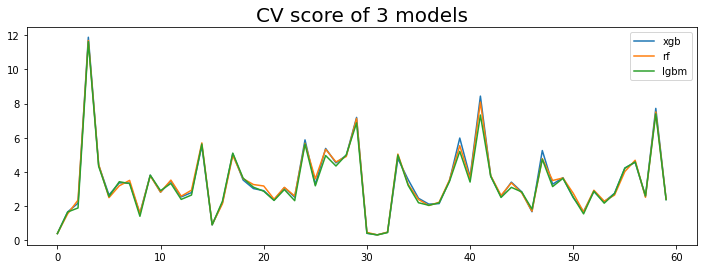

In [24]:
plt.figure(figsize = (12, 4))
plt.plot(xgb_best_cv_result.mean_test_score * (-1), label = 'xgb')
plt.plot(rf_best_cv_result.mean_test_score * (-1), label = 'rf')
plt.plot(lgbm_best_cv_result.mean_test_score * (-1), label = 'lgbm')
plt.title("CV score of 3 models", size = 20)
plt.legend()
plt.show()

3개의 모델이 각 데이터에 대해 비슷한 수준의 성능을 보여줍니다.

lgbm 모델 기준으로 train smape가 가장 좋지 않은 4번 건물과 가장 좋은 32번 건물의 그래프를 비교하며 에러 분석을 실시해보도록 하겠습니다. 

In [25]:
# 4번 건물의 train smape

smape(y_train_list[3], lgbm_reg_grid[3].predict(X_train_array[3]))

6.180584822555426

In [26]:
# 32번 건물의 smape

smape(y_train_list[31], lgbm_reg_grid[31].predict(X_train_array[31]))

0.18030605665093008

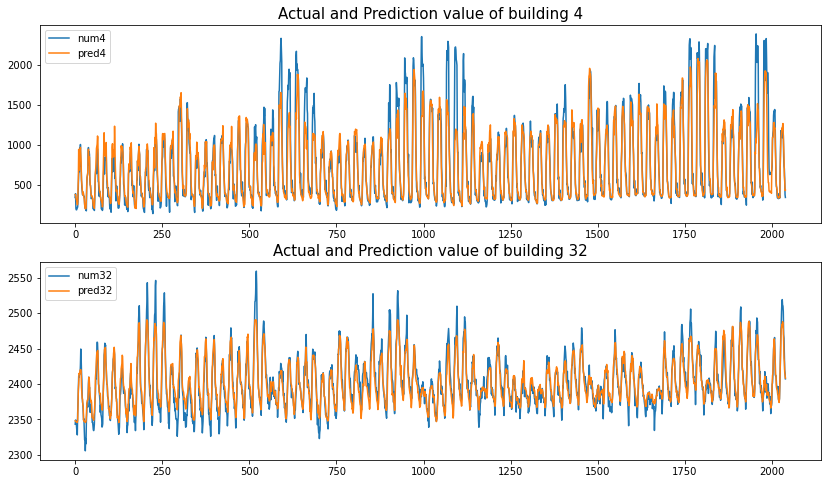

In [27]:
fig, axes = plt.subplots(figsize = (14, 4 * 2), nrows = 2, ncols = 1)
axes = axes.ravel()

axes[0].plot(y_train_list[3], label = 'num4')
axes[0].plot(lgbm_reg_grid[3].predict(X_train_array[3]), label = 'pred4')
axes[0].set_title("Actual and Prediction value of building 4", size = 15)
axes[0].legend()

axes[1].plot(y_train_list[31], label = 'num32')
axes[1].plot(lgbm_reg_grid[31].predict(X_train_array[31]), label = 'pred32')
axes[1].set_title("Actual and Prediction value of building 32", size = 15)
axes[1].legend()

plt.show()

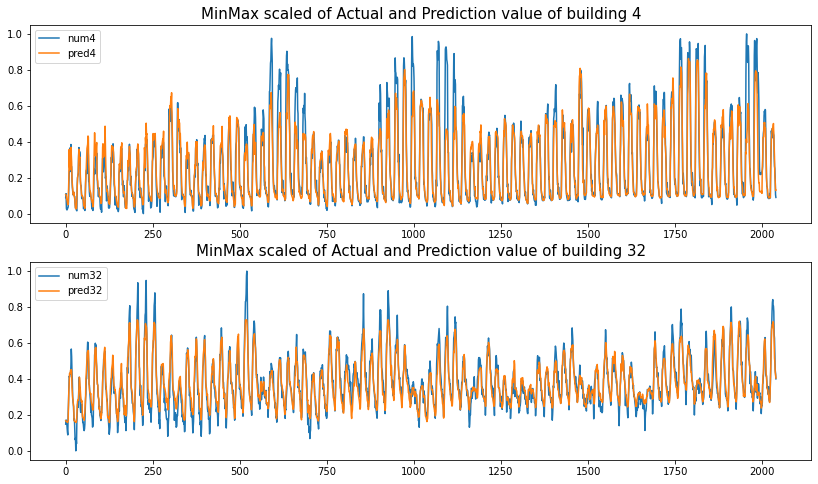

In [28]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_3 = MinMaxScaler()
scaled_3 = MinMaxScaler_3.fit_transform(y_train_list[3].to_numpy().reshape(-1, 1))
pred_scaled_3 = MinMaxScaler_3.transform(lgbm_reg_grid[3].predict(X_train_array[3]).reshape(-1, 1))

MinMaxScaler_31 = MinMaxScaler()
scaled_31 = MinMaxScaler_31.fit_transform(y_train_list[31].to_numpy().reshape(-1, 1))
pred_scaled_31 = MinMaxScaler_31.transform(lgbm_reg_grid[31].predict(X_train_array[31]).reshape(-1, 1))

fig, axes = plt.subplots(figsize = (14, 4 * 2), nrows = 2, ncols = 1)
axes = axes.ravel()

axes[0].plot(scaled_3, label = 'num4')
axes[0].plot(pred_scaled_3, label = 'pred4')
axes[0].set_title("MinMax scaled of Actual and Prediction value of building 4", size = 15)
axes[0].legend()


axes[1].plot(scaled_31, label = 'num32')
axes[1].plot(pred_scaled_31, label = 'pred32')
axes[1].set_title("MinMax scaled of Actual and Prediction value of building 32", size = 15)
axes[1].legend()

plt.show()

y축의 스케일을 0 ~ 1로 고정했을때의 그래프를 보면 성능이 좋은 모델과 좋지 않은 모델 모두 하루(24개 케이스) 중에서 전력사용량 최댓값을 잘 예측하지 못한다는 공통점을 가지고 있습니다.

### 3개 모델의 변수 중요도 비교

건물별로 모델링을 했기 때문에 60개의 모델이 존재하고 모델마다 변수 중요도의 스케일이 다르기 때문에, 각 모델의 변수 중요도의 합으로 변수 중요도를 나눠 스케일을 맞춰 준 뒤 합하여 변수 중요도 그래프를 출력해보도록 하겠습니다.

In [29]:
def scaled_feature_importance(model_grid_list):
    """
    GridSearchCV list를 입력으로 받아 스케일된 변수중요도 출력
    
    60개의 데이터를 각각 다른 모델로 학습했기 때문에 변수 중요도의 스케일이 모델마다 다른 문제점이 존재함
    각 모델의 변수 중요도의 합으로 변수 중요도를 나눠 스케일을 맞춰준 뒤 합하여 결과 반환
    """
    # 각 모델의 변수 중요도의 합을 1로 만들어서 스케일링
    scaled_feature_importance_array = np.concatenate([[model_grid_list[index].best_estimator_.feature_importances_ / 
                                                       np.sum(model_grid_list[index].best_estimator_.feature_importances_)]
                                                      for index in range(60)],
                                                     axis = 0)
    
    # 전역변수 X_train_list를 호출하여 사용
    global X_train_list
    
    # DataFrame 형태로 변환한 뒤 그래프 출력을 위해 오름차순 정렬
    feature_importance_df = pd.DataFrame(np.sum(scaled_feature_importance_array, axis = 0),
                                         columns = ['feature_importance'],
                                         index = X_train_list[0].columns).sort_values(by = 'feature_importance',
                                                                                      ascending = True)
    
    return feature_importance_df

In [30]:
xgb_scaled_feature_importance = scaled_feature_importance(xgb_reg_grid)
rf_scaled_feature_importance = scaled_feature_importance(rf_reg_grid)
lgbm_scaled_feature_importance = scaled_feature_importance(lgbm_reg_grid)

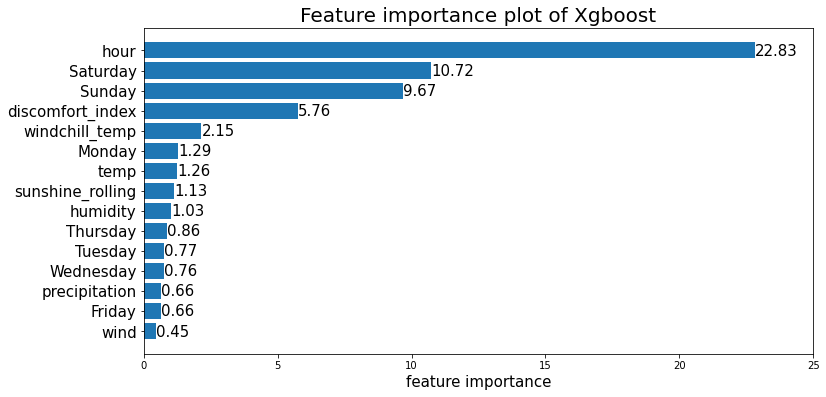

In [31]:
plt.figure(figsize = (12, 6))
plt.barh(xgb_scaled_feature_importance.index, xgb_scaled_feature_importance.feature_importance)

for index, value in enumerate(xgb_scaled_feature_importance.feature_importance):
    plt.text(value, index - 0.25, "{}".format(round(value, 2)), fontsize = 15)

plt.title("Feature importance plot of Xgboost", fontsize = 20)
plt.xlabel('feature importance', fontsize = 15)
plt.xlim((0, 25))
plt.yticks(fontsize = 15)
plt.show()

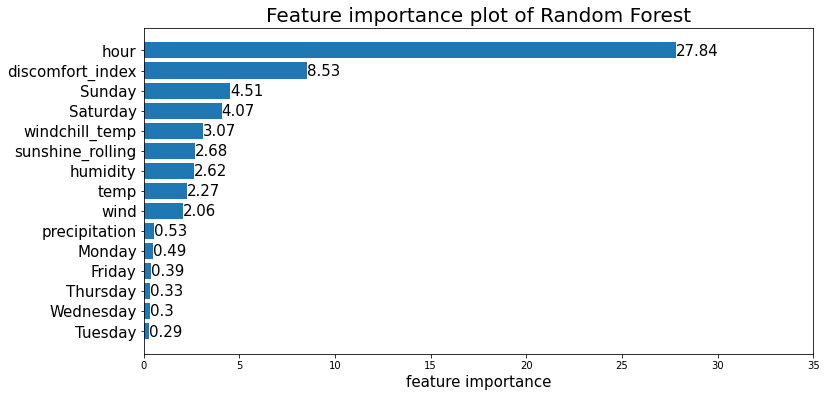

In [32]:
plt.figure(figsize = (12, 6))
plt.barh(rf_scaled_feature_importance.index, rf_scaled_feature_importance.feature_importance)

for index, value in enumerate(rf_scaled_feature_importance.feature_importance):
    plt.text(value, index - 0.25, "{}".format(round(value, 2)), fontsize = 15)

plt.title("Feature importance plot of Random Forest", fontsize = 20)
plt.xlabel('feature importance', fontsize = 15)
plt.xlim((0, 35))
plt.yticks(fontsize = 15)
plt.show()

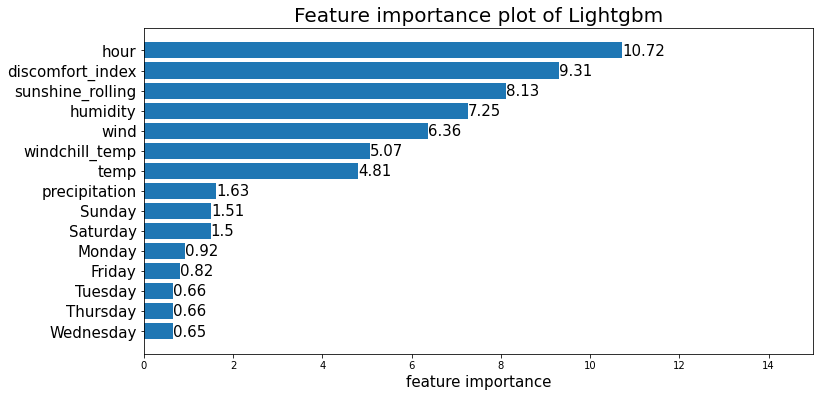

In [33]:
plt.figure(figsize = (12, 6))
plt.barh(lgbm_scaled_feature_importance.index, lgbm_scaled_feature_importance.feature_importance)

for index, value in enumerate(lgbm_scaled_feature_importance.feature_importance):
    plt.text(value, index - 0.25, "{}".format(round(value, 2)), fontsize = 15)

plt.title("Feature importance plot of Lightgbm", fontsize = 20)
plt.xlabel('feature importance', fontsize = 15)
plt.xlim((0, 15))
plt.yticks(fontsize = 15)
plt.show()

모델별로 변수 중요도가 가장 높은 변수 3개와 가장 낮은 변수 3개는 다음과 같습니다.

1. Xgboost

- 변수 중요도 높은 변수 : hour, Saturday, Sunday

- 변수 중요도 낮은 변수 : precipitation, Friday, wind


2. Random Forest

- 변수 중요도 높은 변수 : hour, discomfort_index, Sunday

- 변수 중요도 낮은 변수 : Thursday, Wednesday, Tuesday


3. Lightgbm

- 변수 중요도 높은 변수 : hour, discomfort_index, sunshine_rolling

- 변수 중요도 낮은 변수 : Tuesday, Thursday, Wednesday


3개의 모델에서 변수 중요도가 가장 높은 변수는 hour(시간)입니다. 파생변수인 discomfort_index(불쾌지수), sunshine_rolling(일조량 이동평균)이 Random Forest, Lightgbm 모델에서 변수 중요도 순위권에 들어가 있는 것을 확인할 수 있습니다. 

요일의 더미 변수 중 평일을 의미하는 변수의 중요도가 낮은 것을 확인할 수 있습니다. 변수 개수를 줄이고 싶다면 요일 더미 변수들을 주말여부(평일, 토, 일)로 요약하는 방법을 고려해볼 수 있다고 생각합니다. precipitation(강수량) 변수도 변수 중요도 하위 5순위 안에 공통적으로 들어있는 것을 확인할 수 있습니다.

부스팅(Xgboost, Lightgbm)에 비해 Random Forest 모델에서 가장 변수 중요도가 높은 변수인 hour(시간)의 비중이 큰 것을 확인할 수 있습니다.

## 향후 개선 방향

문제점을 해결하기 위한 개선 방향은 다음과 같습니다.

1. 모델의 학습 파라미터를 더 미세하게 조정하여 성능 향상

2. 오류가 큰 케이스를 설명할 수 있는 잠재변수 발굴

3. 최댓값을 잘 예측할 수 있는 모델을 찾아 모델 대체

4. 다른 에러 양상을 가지는 모델을 찾아 앙상블

## test data prediction

weighted ensemble은 각 모델의 성능의 역수를 가중치로 사용해서 앙상블 예측값을 계산했습니다.

성능의 역수를 가중치로 사용한 이유는 성능 지표값이 높을수록 좋지 않은 모델이기 때문입니다.

In [34]:
xgb_y_test_pred = [xgb_reg_grid[index].predict(X_test_list[index]) for index in range(60)]
rf_y_test_pred = [rf_reg_grid[index].predict(X_test_list[index]) for index in range(60)]
lgbm_y_test_pred = [lgbm_reg_grid[index].predict(X_test_list[index]) for index in range(60)]

xgb_y_test_pred_all = np.concatenate(xgb_y_test_pred, axis = 0)
rf_y_test_pred_all = np.concatenate(rf_y_test_pred, axis = 0)
lgbm_y_test_pred_all = np.concatenate(lgbm_y_test_pred, axis = 0)

In [35]:
# ensemble

ensemble_weight = np.concatenate([
    1 / ((-1) * np.asarray(xgb_best_cv_result.mean_test_score).reshape(-1, 1)),
    1 / ((-1) * np.asarray(rf_best_cv_result.mean_test_score).reshape(-1, 1)),
    1 / ((-1) * np.asarray(lgbm_best_cv_result.mean_test_score).reshape(-1, 1))
],
    axis = 1)

weighted_ensemble_y_test_pred = [
    (ensemble_weight[index, 0] * xgb_y_test_pred[index] +
     ensemble_weight[index, 1] * rf_y_test_pred[index] +
     ensemble_weight[index, 2] * lgbm_y_test_pred[index]) / np.sum(ensemble_weight[index, :])
    for index in range(60)
]

simple_ensemble_y_test_pred_all = (xgb_y_test_pred_all + rf_y_test_pred_all + lgbm_y_test_pred_all) / 3
weighted_ensemble_y_test_pred_all = np.concatenate(weighted_ensemble_y_test_pred, axis = 0)

In [36]:
sample_submission1 = sample_submission.copy()
sample_submission2 = sample_submission.copy()
sample_submission3 = sample_submission.copy()
sample_submission4 = sample_submission.copy()
sample_submission5 = sample_submission.copy()

In [37]:
sample_submission1['answer'] = xgb_y_test_pred_all
sample_submission2['answer'] = rf_y_test_pred_all
sample_submission3['answer'] = lgbm_y_test_pred_all
sample_submission4['answer'] = simple_ensemble_y_test_pred_all
sample_submission5['answer'] = weighted_ensemble_y_test_pred_all

In [38]:
# sample_submission1.to_csv('./submission/90_xgb_reg_grid_list.csv',
#                          index = False)

# sample_submission2.to_csv('./submission/90_rf_reg_grid_list.csv',
#                          index = False)

# sample_submission3.to_csv('./submission/90_lgbm_reg_grid_list.csv',
#                          index = False)

# sample_submission4.to_csv('./submission/90_simple_ensemble.csv',
#                          index = False)

# sample_submission5.to_csv('./submission/90_weighted_ensemble.csv',
#                          index = False)

## dacon website test score

sample_submission1 (xgboost) : 7.9461635351

sample_submission2 (random forest) : 8.0588218039

sample_submission3 (lgbm): 7.0210975869

sample_submission4 (simple ensemble): 7.3014457469

sample_submission5 (weighted ensemble): 7.3036576792

# 모델링 결과 성능 정리

- 전처리 방법

1 : 월, 시간을 정수형 변수로 사용, 건물 군집 번호를 정수형 변수로 사용

2 : 건물 번호, 요일을 원핫인코딩해서 사용, 일조량 변수의 이동평균, 체감온도, 불쾌지수를 파생변수로 사용

In [39]:
modeling_result = pd.DataFrame({
    '전처리 방법' : [1, 1,
               2, 2, 2, 2, 2,
               2, 2, 2, 2, 2],
    '모델' : ['Xgboost', 'Lasso',
           'Xgboost', 'Random Forest', 'Lightgbm', 'Simple Ensemble', 'Weighted Ensemble',
           'Xgboost', 'Random Forest', 'Lightgbm', 'Simple Ensemble', 'Weighted Ensemble'],
    'objective' : ['mse', 'mse', 
                  'mse', 'mse', 'mse', 'mse', 'mse',
                  'mae', 'mae', 'mae', 'mae', 'mae'],
    'CV SMAPE' : [25.002795374262252, 25.908980512288654,
                 3.447886183089466, 3.4374174056523015, 3.453547802512631, None, None,
                 3.447886183089466, 3.4397644364187845, 3.3414076710885063, None, None],
    'Test SMAPE' : [32.113861307, 33.1894393113,
                   7.9461635351, 7.6233149001, 7.1884082184, 7.2497439626, 7.2533592019,
                   7.9461635351, 8.0588218039, 7.0210975869, 7.3014457469, 7.3036576792]
})

In [40]:
modeling_result

,전처리 방법,모델,objective,CV SMAPE,Test SMAPE
0,1,Xgboost,mse,25.002795,32.113861
1,1,Lasso,mse,25.908981,33.189439
2,2,Xgboost,mse,3.447886,7.946164
3,2,Random Forest,mse,3.437417,7.623315
4,2,Lightgbm,mse,3.453548,7.188408
5,2,Simple Ensemble,mse,NaN,7.249744
6,2,Weighted Ensemble,mse,NaN,7.253359
7,2,Xgboost,mae,3.447886,7.946164
8,2,Random Forest,mae,3.439764,8.058822
9,2,Lightgbm,mae,3.341408,7.021098
